## DTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def SampleOnCircle(N_obs=100, N_out=0, is_plot=False):
    '''
    Sample N_obs points from the uniform distribution on the unit circle in R^2,
    and N_out points from the uniform distribution on the unit square
    
    Input:
    N_obs: number of sample points on the circle
    N_out: number of sample points on the square
    is_plot = True or False: draw a plot of the sampled points
    
    Output:
    data: a (N_obs + N_out)x2 matrix, the sampled points concatenated
    '''
    
    rand_uniform = np.random.rand(N_obs)*2-1
    X_obs = np.cos(2*np.pi*rand_uniform)
    Y_obs = np.sin(2*np.pi*rand_uniform)
    
    X_out = np.random.rand(N_out)*2-1
    Y_out = np.random.rand(N_out)*2-1
    
    X = np.concatenate((X_obs,X_out))
    Y = np.concatenate((Y_obs, Y_out))
    data = np.stack((X,Y)).transpose()
    
    if is_plot:
        fig, ax = plt.subplots()
        plt_obs = ax.scatter(X_obs, Y_obs, c='tab:cyan')
        plt_out = ax.scatter(X_out, Y_out, c='tab:orange')
        ax.axis('equal')
        ax.set_title(str(N_obs)+'-sampling of the unit circle with '+str(N_out)+' outliers')
        ax.legend((plt_obs, plt_out), ('data', 'outliers'), loc='lower left')
    return data

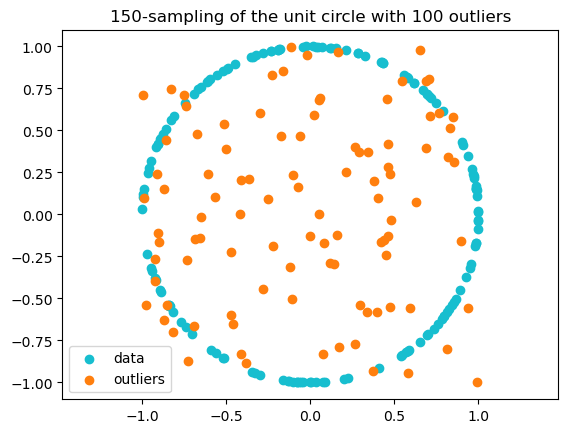

In [2]:
N_obs = 150
N_out = 100
X = SampleOnCircle(N_obs, N_out, is_plot=True)

Text(0.5, 1.0, 'Values of -DTM on X with parameter q=40')

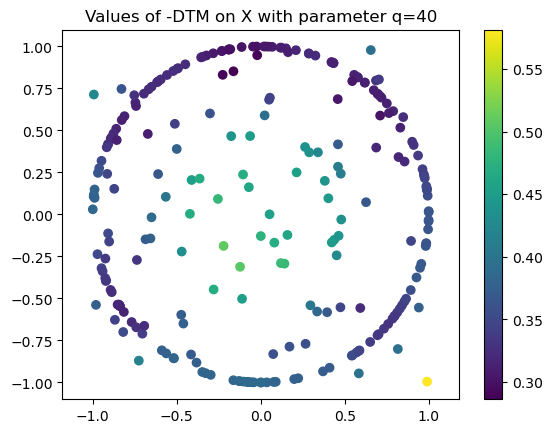

In [3]:
from gudhi.point_cloud.dtm import DistanceToMeasure

q = 40
dtm = DistanceToMeasure(q)
DTM_values = dtm.fit_transform(X)

fig, ax = plt.subplots()
plot = ax.scatter(X[:,0], X[:,1], c=DTM_values)
fig.colorbar(plot)
ax.axis('equal')
ax.set_title('Values of -DTM on X with parameter q='+str(q))

## k-PDTM

In [4]:
def mean_var(X,x,q,kdt):
    '''
    An auxiliary function.
    
    Input:
    X: an nxd numpy array representing n points in R^d
    x: an sxd numpy array representing s points, 
        for each of these points we compute the mean and variance of the nearest neighbors in X
    q: parameter of the DTM in {1,2,...,n} - number of nearest neighbors to consider
    kdt: a KDtree obtained from X via the expression KDTree(X, leaf_size=30, metric='euclidean')
    
    Output:
    Mean: an sxd numpy array containing the means of nearest neighbors
    Var: an sx1 numpy array containing the variances of nearest neighbors
    
    Example:
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    x = np.array([[2,3],[0,0]])
    kdt = KDTree(X, leaf_size=30, metric='euclidean')
    Mean, Var = mean_var(X,x,2,kdt)
    '''
    NN = kdt.query(x, q, return_distance=False)
    Mean = np.mean(X[NN],axis=1)
    Var = np.var(X[NN],axis=1).sum(axis=-1)
    return Mean, Var

from sklearn.neighbors import KDTree
import random # For the random centers from which the algorithm starts


def optima_for_kPDTM(X,q,k,sig,iter_max = 10,nstart = 1):
    '''
    Compute local optimal centers for the k-PDTM-criterion $R$ for the point cloud X
    Require sklearn.neighbors.KDTree to search nearest neighbors
    
    Input:
    X: an nxd numpy array representing n points in R^d
    query_pts:  an sxd numpy array of query points
    q: parameter of the DTM in {1,2,...,n}
    k: number of centers
    sig: number of sample points that the algorithm keeps (the other ones are considered as outliers -- cf section "Detecting outliers")
    iter_max : maximum number of iterations for the optimisation algorithm
    nstart : number of starts for the optimisation algorithm
    
    Output: 
    centers: a kxd numpy array contaning the optimal centers c^*_i computed by the algorithm
    means: a kxd numpy array containing the local centers m(c^*_i,\mathbb X,q)
    variances: a kx1 numpy array containing the local variances v(c^*_i,\mathbb X,q)
    colors: a size n numpy array containing the colors of the sample points in X
        points in the same weighted Voronoi cell (with centers in opt_means and weights in opt_variances)
        have the same color
    cost: the mean, for the "sig" points X[j,] considered as signal, of their smallest weighted distance to a center in "centers"
        that is, min_i\|X[j,]-means[i,]\|^2+variances[i].
        
    
    Example:
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    sig = X.shape[0] # There is no trimming, all sample points are assigned to a cluster
    centers, means, variances, colors, cost = optima_for_kPDTM(X, 3, 2, sig)
    '''
    n = X.shape[0]
    d = X.shape[1]
    opt_cost = np.inf
    opt_centers = np.zeros([k,d])
    opt_colors = np.zeros(n)
    opt_kept_centers = np.zeros(k)
    if(q<=0 or q>n):
        raise AssertionError("Error: q should be in {1,2,...,n}")
    elif(k<=0 or k>n):
        raise AssertionError("Error: k should be in {1,2,...,n}")
    else:
        kdt = KDTree(X, leaf_size=30, metric='euclidean')
        for starts in range(nstart):
            
            # Initialisation
            colors = np.zeros(n)
            min_distance = np.zeros(n) # Weighted distance between a point and its nearest center
            kept_centers = np.ones((k), dtype=bool)
            first_centers_ind = random.sample(range(n), k) # Indices of the centers from which the algorithm starts
            centers = X[first_centers_ind,:]
            old_centers = np.ones([k,d])*np.inf
            mv = mean_var(X,centers,q,kdt)
            Nstep = 1
            while(not np.array_equal(old_centers, centers) and Nstep <= iter_max):
                Nstep = Nstep + 1
                
                # Step 1: Update colors and min_distance
                for j in range(n):
                    distances = np.sum((X[j,None,:]-mv[0][kept_centers])**2,axis=-1) + mv[1][kept_centers]
                    best_among_kept = np.argmin(distances)
                    min_distance[j] = distances[best_among_kept]
                    colors[j] = np.arange(k)[kept_centers][best_among_kept]

                # Step 2: Trimming step - Put color -1 to the (n-sig) points with largest cost
                index = np.argsort(-min_distance)
                colors[index[range(n-sig)]] = -1
                ds = min_distance[index[range(n-sig,n)]]
                costt = np.mean(ds)
                
                # Step 3: Update Centers and mv
                old_centers = np.copy(centers)
                old_mv = mv
                for i in range(k):
                    if kept_centers[i]:
                        color_i = colors == i
                        if(color_i.any()):
                            centers[i,] = np.mean(X[color_i,],axis = 0)
                        else:
                            kept_centers[i] = False
                mv = mean_var(X,centers,q,kdt)
                
            if(costt <= opt_cost):
                opt_cost = costt
                opt_centers = np.copy(old_centers)
                opt_mv = old_mv
                opt_colors = np.copy(colors)
                opt_kept_centers = np.copy(kept_centers)
                
        centers = opt_centers[opt_kept_centers,]
        means = opt_mv[0][opt_kept_centers,]
        variances = opt_mv[1][opt_kept_centers]
        colors = np.zeros(n)
        for i in range(n):
            colors[i] = np.sum(opt_kept_centers[range(int(opt_colors[i]+1))])-1
        cost = opt_cost
        
    return(centers, means, variances, colors, cost)


def kPDTM(X,query_pts,q,k,sig,iter_max = 10,nstart = 1):
    '''
    Compute the values of the k-PDTM of the empirical measure of a point cloud X
    Require sklearn.neighbors.KDTree to search nearest neighbors
    
    Input:
    X: a nxd numpy array representing n points in R^d
    query_pts:  a sxd numpy array of query points
    q: parameter of the DTM in {1,2,...,n}
    k: number of centers
    sig: number of points considered as signal in the sample (other signal points are trimmed)
    
    Output: 
    kPDTM_result: a sx1 numpy array contaning the kPDTM of the 
    query points
    
    Example:
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    Q = np.array([[0,0],[5,5]])
    kPDTM_values = kPDTM(X, Q, 3, 2,X.shape[0])
    '''
    n = X.shape[0]     
    if(q<=0 or q>n):
        raise AssertionError("Error: q should be in {1,2,...,n}")
    elif(k<=0 or k>n):
        raise AssertionError("Error: k should be in {1,2,...,n}")
    elif(X.shape[1]!=query_pts.shape[1]):
        raise AssertionError("Error: X and query_pts should contain points with the same number of coordinates.")
    else:
        centers, means, variances, colors, cost = optima_for_kPDTM(X,q,k,sig,iter_max = iter_max,nstart = nstart)
        kPDTM_result = np.min(np.sum((query_pts[:,None,:]-means[None,:,:])**2,axis=-1)+variances[None,:],axis=-1)
        kPDTM_result = np.sqrt(kPDTM_result)

    return(kPDTM_result, centers, means, variances, colors, cost)

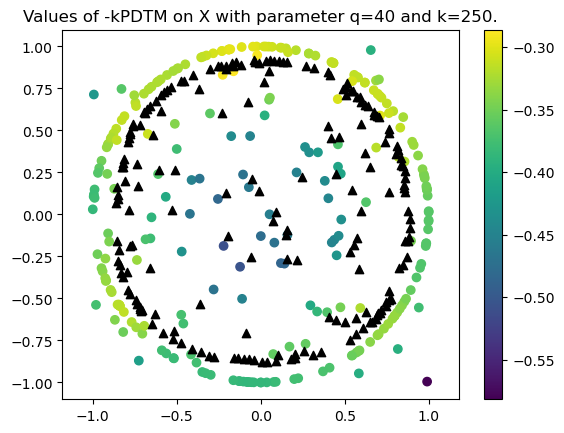

In [5]:
#compute k-PDTM
q = 40
k = 250
sig = X.shape[0]
iter_max = 100
nstart = 10
kPDTM_values, centers, means, variances, colors, cost = kPDTM(X,X,q,k,sig,iter_max,nstart)  


fig, ax = plt.subplots()
plot = ax.scatter(X[:,0], X[:,1], c=-kPDTM_values)
fig.colorbar(plot)
for i in range(means.shape[0]):
    ax.scatter(means[i,0],means[i,1],c = "black",marker = "^")
ax.axis('equal')
ax.set_title('Values of -kPDTM on X with parameter q='+str(q)+' and k='+str(k)+'.');

## k-PLM

In [6]:
from scipy.spatial import distance # For the Mahalanobis distance

def optima_for_kPLM(X,q,k,sig,iter_max = 10,nstart = 1):
    '''
    Compute local optimal centers and matrices for the k-PLM-criterion $R'$ for the point cloud X    
    Input:
    X: an nxd numpy array representing n points in R^d
    query_pts:  an sxd numpy array of query points
    q: parameter of the DTM in {1,2,...,n}
    k: number of centers
    sig: number of sample points that the algorithm keeps (the other ones are considered as outliers -- cf section "Detecting outliers")
    iter_max : maximum number of iterations for the optimisation algorithm
    nstart : number of starts for the optimisation algorithm
    
    Output: 
    centers: a kxd numpy array contaning the optimal centers c^*_i computed by the algorithm
    Sigma: a list of dxd numpy arrays containing the covariance matrices associated to the centers
    means: a kxd numpy array containing the centers of ellipses that are the sublevels sets of the k-PLM
    weights: a size k numpy array containing the weights associated to the means
    colors: a size n numpy array containing the colors of the sample points in X
        points in the same weighted Voronoi cell (with centers in means and weights in weights)
        have the same color    
    cost: the mean, for the "sig" points X[j,] considered as signal, of their smallest weighted distance to a center in "centers"
        that is, min_i\|X[j,]-means[i,]\|_{Sigma[i]^(-1)}^2+weights[i].         
    
    Example:
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    sig = X.shape[0] # There is no trimming, all sample points are assigned to a cluster
    centers, Sigma, means, weights, colors, cost = optima_for_kPLM(X, 3, 2, sig)
    '''
    n = X.shape[0]
    d = X.shape[1]
    opt_cost = np.inf
    opt_centers = np.zeros([k,d])
    opt_Sigma = []
    opt_means = np.zeros([k,d])
    opt_weights = np.zeros(k)
    opt_colors = np.zeros(n)
    opt_kept_centers = np.zeros(k)
    if(q<=0 or q>n):
        raise AssertionError("Error: q should be in {1,2,...,n}")
    elif(k<=0 or k>n):
        raise AssertionError("Error: k should be in {1,2,...,n}")
    else:
        #kdt = KDTree(X, leaf_size=30, metric='euclidean')
        for starts in range(nstart):
            
            # Initialisation
            colors = np.zeros(n)
            kept_centers = np.ones((k), dtype=bool)
            first_centers_ind = random.sample(range(n), k) # Indices of the centers from which the algorithm starts
            centers = X[first_centers_ind,:]
            old_centers = np.ones([k,d])*np.inf
            Sigma = [np.identity(d)]*k
            old_Sigma = np.copy(Sigma)
            old_mi = np.zeros([k,d])
            old_weights = np.zeros(k)
            
            mi = np.zeros([k,d]) # means
            vi = np.zeros(k) # variances for the mahalanobis norms
            ci = np.zeros(k) # log(det(Sigma))
            
            Nstep = 1
            continue_Sigma = True
            
            while((continue_Sigma or (np.sum(old_centers!=centers)>0)) and (Nstep <= iter_max)):
                Nstep = Nstep + 1
                
                # Step 1: Update mi, vi and ci
                for i in range(k):
                    index = np.argsort([distance.mahalanobis(X[j,], centers[i,], np.linalg.inv(Sigma[i])) for j in range(X.shape[0])])
                    index = index[range(q)]
                    mi[i,] = np.mean(X[index,], axis = 0)
                    vect_aux = [distance.mahalanobis(X[index[j],], mi[i,], np.linalg.inv(Sigma[i])) for j in range(q)]
                    vi[i] = np.mean([val*val for val in vect_aux]) # The square of the Mahalanobis distance
                    sign, ci[i] = np.linalg.slogdet(Sigma[i]) # log(det(Sigma[i]))
                                     
                # Step 2: Update colors and min_distance
                min_distance = np.zeros(n) # Weighted distance between a point and its nearest center
                for j in range(n):
                    cost = np.inf
                    best_ind = 0
                    for i in range(k):
                        if(kept_centers[i]):
                            aux = distance.mahalanobis(X[j,],mi[i,],np.linalg.inv(Sigma[i]))
                            newcost = aux*aux + vi[i] + ci[i]
                            if (newcost < cost):
                                cost = newcost
                                best_ind = i
                    colors[j] = best_ind
                    min_distance[j] = cost
                    
                # Step 3: Trimming step - Put color -1 to the (n-sig) points with largest cost
                index = np.argsort(-min_distance)
                colors[index[range(n-sig)]] = -1
                ds = min_distance[index[range(n-sig,n)]]
                costt = np.mean(ds)
                
                # Step 4: Update Centers and mi and Sigma
                old_centers = np.copy(centers)
                old_mi = np.copy(mi)
                old_weights = vi+ci
                old_Sigma = np.copy(Sigma)
                for i in range(k):
                    pointcloud_size = np.sum(colors == i)
                    if(pointcloud_size>1):
                        centers[i,] = np.mean(X[colors==i,],axis = 0)  
                        index = np.argsort([distance.mahalanobis(X[j,], centers[i,], np.linalg.inv(Sigma[i])) for j in range(X.shape[0])])
                        index = index[range(q)]
                        mi[i,] = np.mean(X[index,], axis = 0)
                        aa = np.dot(np.array([mi[i,]-centers[i,]]).T,np.array([mi[i,]-centers[i,]]))
                        bb = (q-1)/q*np.cov(np.array([X[index[j],] for j in range(q)]).T)
                        cc = (pointcloud_size - 1)/(pointcloud_size)*np.cov(np.array(X[colors==i,]).T)
                        Sigma[i] = aa+bb+cc
                    elif(pointcloud_size==1):
                        centers[i,] = np.mean(X[colors==i,],axis = 0)  
                        index = np.argsort([distance.mahalanobis(X[j,], centers[i,], np.linalg.inv(Sigma[i])) for j in range(X.shape[0])])
                        index = index[range(q)]
                        mi[i,] = np.mean(X[index,], axis = 0)
                        aa = np.dot(np.array([mi[i,]-centers[i,]]).T,np.array([mi[i,]-centers[i,]]))
                        bb = (q-1)/q*np.cov(np.array([X[index[j],] for j in range(q)]).T)
                        Sigma[i] = aa + bb
                    else:
                        kept_centers[i] = False
                Stop_Sigma = True # True while old_Sigma = Sigma
                for i in range(k):
                    if(kept_centers[i]):
                        Stop_Sigma = (Stop_Sigma and (np.sum([old_Sigma[i]!=Sigma[i]])==0))
                continue_Sigma = not Stop_Sigma
                
            if(costt <= opt_cost):
                opt_cost = costt
                opt_centers = np.copy(old_centers)
                opt_means = np.copy(old_mi)
                opt_weigths = np.copy(old_weights)
                opt_Sigma = np.copy(old_Sigma)
                opt_colors = np.copy(colors)
                opt_kept_centers = np.copy(kept_centers)
                
        centers = opt_centers[opt_kept_centers,]
        Sigma = [opt_Sigma[i] for i in range(k) if opt_kept_centers[i]]#### ATTENTION !!!!
        means = opt_means[opt_kept_centers,]
        weights = opt_weigths[opt_kept_centers]
        colors = np.zeros(n)
        for i in range(n):
            colors[i] = np.sum(opt_kept_centers[range(int(opt_colors[i]+1))])-1
        cost = opt_cost
        
    return(centers, Sigma, means, weights, colors, cost)


def kPLM(X,query_pts,q,k,sig,iter_max = 10,nstart = 1):
    '''
    Compute the values of the k-PDTM of the empirical measure of a point cloud X
    Require sklearn.neighbors.KDTree to search nearest neighbors
    
    Input:
    X: a nxd numpy array representing n points in R^d
    query_pts:  a sxd numpy array of query points
    q: parameter of the DTM in {1,2,...,n}
    k: number of centers
    sig: number of points considered as signal in the sample (other signal points are trimmed)
    
    Output: 
    kPDTM_result: a sx1 numpy array contaning the kPDTM of the 
    query points
    
    Example:
    X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    Q = np.array([[0,0],[5,5]])
    kPLM_values = kPLM(X, Q, 3, 2,X.shape[0])
    '''
    n = X.shape[0]     
    if(q<=0 or q>n):
        raise AssertionError("Error: q should be in {1,2,...,n}")
    elif(k<=0 or k>n):
        raise AssertionError("Error: k should be in {1,2,...,n}")
    elif(X.shape[1]!=query_pts.shape[1]):
        raise AssertionError("Error: X and query_pts should contain points with the same number of coordinates.")
    else:
        centers, Sigma, means, weights, colors, cost = optima_for_kPLM(X,q,k,sig,iter_max = iter_max,nstart = nstart)
        kPLM_result = np.zeros(query_pts.shape[0])
        for i in range(query_pts.shape[0]):
            kPLM_result[i] = np.inf
            for j in range(means.shape[0]):
                aux0 = distance.mahalanobis(query_pts[i,],means[j,],np.linalg.inv(Sigma[j]))
                aux = aux0*aux0 + weights[j] # We don't take the squareroot, since aux could be negative
                if(aux<kPLM_result[i]):
                    kPLM_result[i] = aux 
                    
    return(kPLM_result, centers, Sigma, means, weights, colors, cost)

Text(0.5, 1.0, 'Values of -kPLM on X with parameter q=40 and k=250.')

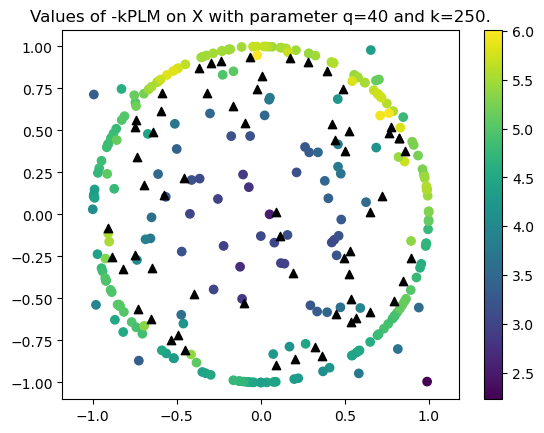

In [7]:
#compute k-PLM
q = 40
k = 250
sig = X.shape[0]
iter_max = 10
nstart = 1
kPLM_values, centers, Sigma, means, weights, colors, cost = kPLM(X,X,q,k,sig,iter_max,nstart)  

fig, ax = plt.subplots()
plot = ax.scatter(X[:,0], X[:,1], c=-kPLM_values)
fig.colorbar(plot)
for i in range(means.shape[0]):
    ax.scatter(means[i,0],means[i,1],c = "black",marker = "^")
ax.axis('equal')
ax.set_title('Values of -kPLM on X with parameter q='+str(q)+' and k='+str(k)+'.')

## trimmed version

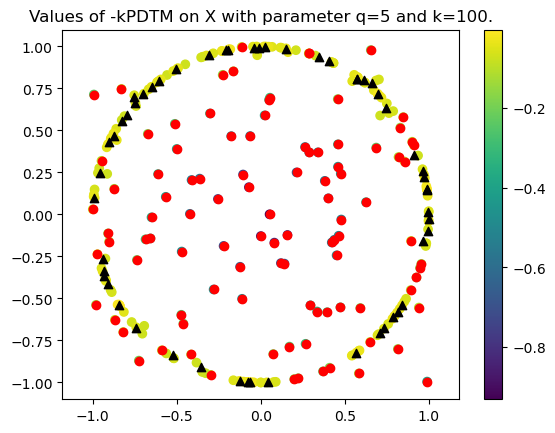

In [8]:
# Compute the trimmed k-PDTM
q = 5
k = 100
sig = 150 # Amount of signal points - We will remove o = 250 - 150 points from the sample
iter_max = 100
nstart = 10
kPDTM_values, centers, means, variances, colors, cost = kPDTM(X,X,q,k,sig,iter_max,nstart)  

fig, ax = plt.subplots()
plot = ax.scatter(X[:,0], X[:,1], c=-kPDTM_values)
fig.colorbar(plot)
for i in range(means.shape[0]):
    ax.scatter(means[i,0],means[i,1],c = "black",marker = "^")
for j in range(X.shape[0]):
    if (colors[j]==-1):
        ax.scatter(X[j,0], X[j,1], c="red")
ax.axis('equal')
ax.set_title('Values of -kPDTM on X with parameter q='+str(q)+' and k='+str(k)+'.');

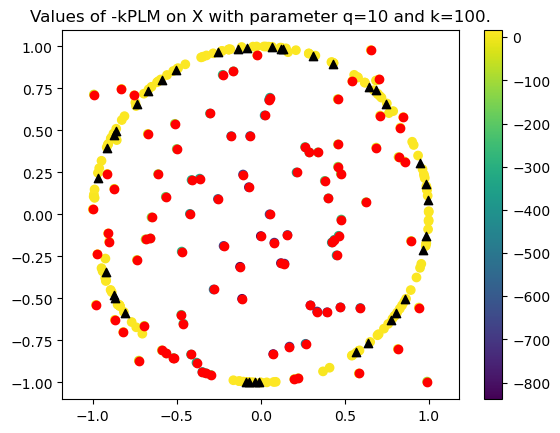

In [9]:
# Compute the trimmed k-PLM
q = 10
k = 100
sig = 150
iter_max = 10
nstart = 1
kPLM_values, centers, Sigma, means, weights, colors, cost = kPLM(X,X,q,k,sig,iter_max,nstart)  

fig, ax = plt.subplots()
plot = ax.scatter(X[:,0], X[:,1], c=-kPLM_values)
fig.colorbar(plot)
for i in range(means.shape[0]):
    ax.scatter(means[i,0],means[i,1],c = "black",marker = "^")
for j in range(X.shape[0]):
    if (colors[j]==-1):
        ax.scatter(X[j,0], X[j,1], c="red")
ax.axis('equal')
ax.set_title('Values of -kPLM on X with parameter q='+str(q)+' and k='+str(k)+'.');

## Sublevel set

In [10]:
import math
import matplotlib

def Trace_ellipses(Sigma,center,alpha):
    w, v =  np.linalg.eig(Sigma)
    index = np.argsort(-abs(w))
    return(matplotlib.patches.Ellipse(center, 2*np.sqrt(alpha*w[index[0]]), 2*np.sqrt(alpha*w[index[1]]), angle= -180/math.pi*np.sign(v[index[0]][1])*math.acos(v[index[0]][0])))

def Trace_balls(center,alpha):
    return(matplotlib.patches.Circle(center, np.sqrt(alpha)))

Text(0.5, 1.0, 'Sublevel sets of the kPDTM on X with parameters q=5 and k=100.')

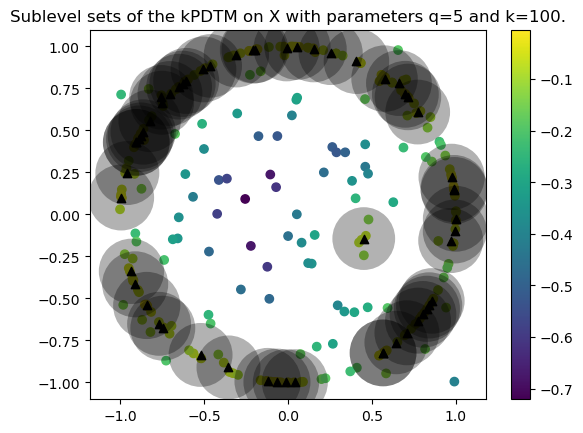

In [11]:
#compute sublevel set of k-PDTM
q = 5
k = 100
sig = 150
iter_max = 10
nstart = 1
kPDTM_values, centers, means, variances, colors, cost = kPDTM(X,X,q,k,sig,iter_max,nstart)  
# plot of  the opposite of the k-PDTM
fig, ax = plt.subplots()
plot = ax.scatter(X[:,0], X[:,1], c=-kPDTM_values)
fig.colorbar(plot)

alpha = 0.2 # Level for the sub-level set of the k-PLM
Circle = [Trace_balls(means[i,],max(0,alpha*alpha - variances[i])) for i in range(means.shape[0])]
for cir in Circle:
    ax.add_artist(cir)
    cir.set_alpha(0.3) # For transparency
    cir.set_facecolor("black")

for i in range(means.shape[0]):
    ax.scatter(means[i,0],means[i,1],c = "black",marker = "^")

ax.axis('equal')
ax.set_title('Sublevel sets of the kPDTM on X with parameters q='+str(q)+' and k='+str(k)+'.')

Text(0.5, 1.0, 'Sublevel sets of the kPLM on X with parameters q=10 and k=100.')

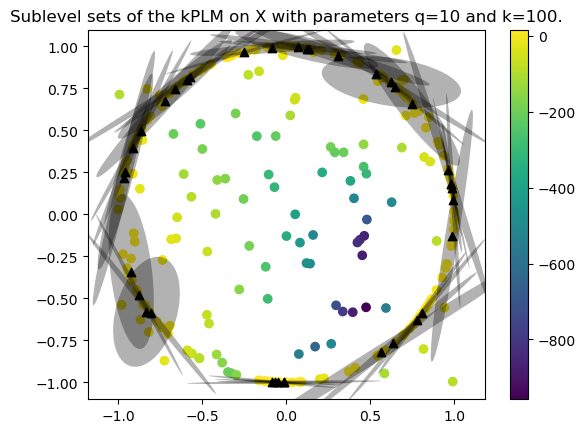

In [12]:
#compute sublevel set of k-PLM
q = 10
k = 100
sig = 150
iter_max = 10
nstart = 1
kPLM_values, centers, Sigma, means, weights, colors, cost = kPLM(X,X,q,k,sig,iter_max,nstart)  
# plot of  the opposite of the k-PLM
fig, ax = plt.subplots()
plot = ax.scatter(X[:,0], X[:,1], c=-kPLM_values)
fig.colorbar(plot)

alpha = 10 # Level for the sub-level set of the k-PLM
Ellipses = [Trace_ellipses(Sigma[i],means[i,],max(0,alpha - weights[i])) for i in range(means.shape[0])]
for ell in Ellipses:
    ax.add_artist(ell)
    ell.set_alpha(0.3) # For transparency
    ell.set_facecolor("black")

for i in range(means.shape[0]):
    ax.scatter(means[i,0],means[i,1],c = "black",marker = "^")
    
ax.axis('equal')
ax.set_title('Sublevel sets of the kPLM on X with parameters q='+str(q)+' and k='+str(k)+'.')